In [22]:
import requests
from bs4 import BeautifulSoup

from selenium.webdriver.common.action_chains import ActionChains
from time import sleep
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import json
import re
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<img src='https://1000logos.net/wp-content/uploads/2021/05/Vanguard-logo.png' width=350>

In [25]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

In [41]:
class VanguardInsights:
    
    def __init__(self, all_insight_link):
        self.all_insight_link = all_insight_link
        service = Service(executable_path=ChromeDriverManager().install())
        self.driver = webdriver.Chrome(service=service)
            
    @staticmethod
    def extract_content_with_id(link):
        response = requests.get(link)
        soup = BeautifulSoup(response.text)
        content = ' '.join([i.text for i in soup.find_all("div", {"id": "iw_placeholder1585759247342"})]).strip()
        return content
            
    def get_article_insight(self):
        
        self.driver.get(self.all_insight_link)
        sleep(10)

        all_pages = []

        for i in range(18):

            title_tags = self.driver.find_elements(By.XPATH,'//*[(@id = "insights-archive-section")]//h3')
            title_contents = self.driver.find_elements(By.XPATH, '//*[(@id = "insights-archive-section")]//*[contains(concat( " ", @class, " " ), concat( " ", "p2", " " ))]')
            date_perspectives = self.driver.find_elements(By.XPATH,'//*[contains(concat( " ", @class, " " ), concat( " ", "eyebrow", " " ))]')
            perspectives = self.driver.find_elements(By.XPATH, '//*[contains(concat( " ", @class, " " ), concat( " ", "type", " " ))]')
            # dates = browser.find_elements(By.CSS_SELECTOR, '.content-eyebrow .eyebrow')
            tags = self.driver.find_elements(By.CSS_SELECTOR, "[id='insights-archive'] [class='tags']")
            tags = [i.find_elements(By.CSS_SELECTOR, "[id='insights-archive'] [class='tags'] [class='pill tag']") for i in tags]
            links = self.driver.find_elements(By.CSS_SELECTOR, '.detail-link')



            title_tag = [i.text for i in title_tags] 
            title_content = [i.text for i in title_contents]
            date_perspective = [i.text for i in date_perspectives]
            date = [''.join(re.findall(r'[A-Z]+\s\d+,\s\d+', i)) for i in date_perspective[1:]]
            perspective = [i.text for i in perspectives]
            #date = [i.text for i in dates]
            tag = [[j.text for j in i]for i in tags]
            links_list = [link.get_attribute('href') for link in links]

            list_of_dict = []
            for tg,tc,d,p,t,l in zip(title_tag, title_content, date, perspective, tag, links_list):
                economy_market_dict = {
                                    'company': 'Vanguard', 
                                    'topic': 'Insight', 
                                    'articel_title': tg, 
                                    'abstract' : tc,
                                    'date' : d,
                                    'perspective' : p,
                                    'tag': ','.join(t),
                                    'link':l,
                                    'content':self.extract_content_with_id(l),
                }
                list_of_dict.append(economy_market_dict)


            all_pages.append(list_of_dict)
            next_page = self.driver.find_element(By.CSS_SELECTOR,'#insights-archive-section > div.pagination > div.pagination__arrows > span.icon.icon-right')
            next_page.click()

        self.driver.quit()
        vanguard_insight_list = []
        for p_8 in all_pages:
            for p in p_8:
                vanguard_insight_list.append(p)
                
        return vanguard_insight_list


    @staticmethod
    def save_to_json(file_path, list_of_dict):
        with open(file_path, 'a') as f:
            for dict_ in list_of_dict:
                json.dump(dict_,f,indent=4)



In [42]:
vanguard_insight_obj = VanguardInsights('https://advisors.vanguard.com/insights/all')
vanguard_insight_list = vanguard_insight_obj.get_article_insight()

In [43]:
df = pd.DataFrame(vanguard_insight_list)

In [44]:
df['tag'].unique()

array(['U.S.', 'Fixed Income,Equities,Portfolio Construction',
       'U.S.,International', 'International', '',
       'Fixed Income,U.S.,Bear Markets', 'ESG Strategies,Equities',
       "Advisor's Alpha®,Behavioral Coaching,Portfolio Construction",
       'Fixed Income', 'Fixed Income,Portfolio Construction',
       'Portfolio Construction', 'ETF Investing', 'U.S.,Fixed Income',
       'Fixed Income,U.S.', 'Equities',
       "Advisor's Alpha®,Behavioral Coaching,Bear Markets",
       "Advisor's Alpha®,Behavioral Coaching",
       "Advisor's Alpha®,Behavioral Coaching,U.S.",
       'Equities,Portfolio Construction', 'ESG Strategies',
       'Behavioral Coaching', 'Fixed Income,Equities',
       'Fixed Income,Bear Markets', 'Fixed Income,Equities,International',
       'International,Bear Markets,Fixed Income', "Advisor's Alpha®",
       'ETF Investing,Fixed Income', 'Wealth Management',
       'ETF Investing,Equities', 'Behavioral Coaching,Wealth Management',
       'ETF Investing,Equ

In [45]:
df['tag2'] = df['tag'].apply(lambda x: x.split(',')[0])

In [49]:
df

,company,topic,articel_title,abstract,date,perspective,tag,link,content,tag2
0,Vanguard,Insight,Getting inside the Fed's head,Three scenarios that the Fed could face in the...,"SEPTEMBER 05, 2022",EXPERT PERSPECTIVE,U.S.,https://advisors.vanguard.com/insights/article...,The task currently facing the Federal Reserve ...,U.S.
1,Vanguard,Insight,Find out how your portfolios stack up,Get insights into how advisors are managing th...,"AUGUST 30, 2022",VANGUARD PERSPECTIVE,"Fixed Income,Equities,Portfolio Construction",https://advisors.vanguard.com/insights/article...,Portfolio Analytics and Consulting is a group ...,Fixed Income
2,Vanguard,Insight,Market perspectives: September 2022,Vanguard September market perspectives offers ...,"AUGUST 29, 2022",VANGUARD PERSPECTIVE,"U.S.,International",https://advisors.vanguard.com/insights/article...,Key highlights\n\nWe place the likelihood of a...,U.S.
3,Vanguard,Insight,Inside Jane Street's ETF trading,Gain expert insight into how the rapidly growi...,"AUGUST 25, 2022",EXPERT PERSPECTIVE,International,https://advisors.vanguard.com/insights/article...,With the accelerating adoption of ETFs comes t...,International
4,Vanguard,Insight,When is personalized indexing right for your c...,Explore potential use cases for personalized i...,"AUGUST 23, 2022",VANGUARD PERSPECTIVE,,https://advisors.vanguard.com/insights/article...,Personalized indexing (also known as custom or...,
...,...,...,...,...,...,...,...,...,...,...
135,Vanguard,Insight,Don't let headlines dictate clients' investing...,"As an advisor, you can ease clients' anxiety d...","MARCH 29, 2020",VANGUARD PERSPECTIVE,"Behavioral Coaching,Wealth Management",https://advisors.vanguard.com/insights/article...,While a downturn in the financial markets is a...,Behavioral Coaching
136,Vanguard,Insight,How are major index providers handling upcomin...,Vanguard's benchmark providers update their pl...,"MARCH 24, 2020",VANGUARD PERSPECTIVE,Equities,https://advisors.vanguard.com/insights/article...,"Given the recent volatility, the increased cos...",Equities
137,Vanguard,Insight,Our 2020 outlook,Download a comprehensive outlook or a quick ov...,"DECEMBER 12, 2019",WHITEPAPER,"U.S.,International",https://advisors.vanguard.com/insights/article...,"Get Vanguard's take on the global economy, mon...",U.S.
138,Vanguard,Insight,Clients confused about Medicare's maze? This g...,Clients' task of choosing a Medicare option ca...,"OCTOBER 22, 2019",WHITEPAPER,"Behavioral Coaching,Wealth Management",https://advisors.vanguard.com/insights/article...,"Key highlights\n\nClients can use a ""prioritiz...",Behavioral Coaching


<AxesSubplot:xlabel='count', ylabel='tag2'>

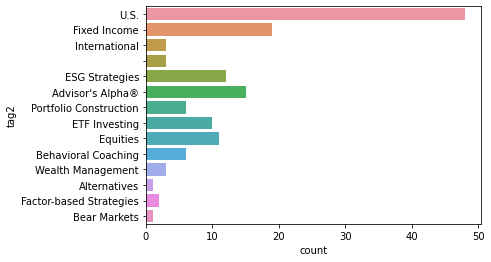

In [48]:
sns.countplot(y=df['tag2'])

In [ ]:
tags = self.driver.find_elements(By.CSS_SELECTOR, "[id='insights-archive'] [class='tags']")
tags = [i.find_elements("[id='insights-archive'] [class='tags'] [class='pill tag']") for i in tags]

In [ ]:
tag = [[j.text for j in i]for i in tags]

In [56]:
d = dict(
        us_num = 0,
        fixed_income_num = 0,
        international_num = 0,
        esg_strategies_num = 0,
        advisor_alpha_num = 0,
        portfolio_construction_num = 0,
        etf_investing_num = 0,
        equities_num = 0,
        behavioral_coaching_num = 0,
        wealth_management_num = 0,
        alternatives_num =0,
        factor_based_strategies_num = 0,
        bear_markets_num = 0)

for i in df['tag']:
    if 'U.S.' in i:
        d['us_num'] += 1
    if 'Fixed Income' in i:
        fixed_income_num += 1
    if 'International' in i:
        international_num += 1
    if 'ESG Strategies' in i:
        esg_strategies_num += 1
    if "Advisor's Alpha®" in i :
        advisor_alpha_num += 1
    if 'Portfolio Construction' in i:
        portfolio_construction_num += 1
    if 'ETF Investing' in i:
        etf_investing_num += 1
    if 'Equities' in i:
        equities_num += 1
    if 'Behavioral Coaching' in i:
        behavioral_coaching_num +=1
    if 'Wealth Management' in i:
        wealth_management_num += 1
    if 'Alternatives' in i:
        alternatives_num +=1
    if 'Factor-based Strategies' in i:
        factor_based_strategies_num +=1
    if 'Bear Markets' in i:
        bear_markets_num +=1

In [52]:
df['tag2'].unique()

array(['U.S.', 'Fixed Income', 'International', '', 'ESG Strategies',
       "Advisor's Alpha®", 'Portfolio Construction', 'ETF Investing',
       'Equities', 'Behavioral Coaching', 'Wealth Management',
       'Alternatives', 'Factor-based Strategies', 'Bear Markets'],
      dtype=object)

In [58]:

d = dict(
        us_num = 0,
        fixed_income_num = 0,
        international_num = 0,
        esg_strategies_num = 0,
        advisor_alpha_num = 0,
        portfolio_construction_num = 0,
        etf_investing_num = 0,
        equities_num = 0,
        behavioral_coaching_num = 0,
        wealth_management_num = 0,
        alternatives_num =0,
        factor_based_strategies_num = 0,
        bear_markets_num = 0)

for i in df['tag']:
    if 'U.S.' in i:
        d['us_num'] += 1
    if 'Fixed Income' in i:
        d['fixed_income_num'] += 1
    if 'International' in i:
        d['international_num'] += 1
    if 'ESG Strategies' in i:
        d['esg_strategies_num'] += 1
    if "Advisor's Alpha®" in i :
        d['advisor_alpha_num'] += 1
    if 'Portfolio Construction' in i:
        d['portfolio_construction_num'] += 1
    if 'ETF Investing' in i:
        d['etf_investing_num'] += 1
    if 'Equities' in i:
        d['equities_num'] += 1
    if 'Behavioral Coaching' in i:
        d['behavioral_coaching_num'] +=1
    if 'Wealth Management' in i:
        d['wealth_management_num'] += 1
    if 'Alternatives' in i:
        d['alternatives_num'] +=1
    if 'Factor-based Strategies' in i:
        d['factor_based_strategies_num'] +=1
    if 'Bear Markets' in i:
        d['bear_markets_num'] +=1

In [59]:
d

{'us_num': 54,
 'fixed_income_num': 24,
 'international_num': 33,
 'esg_strategies_num': 12,
 'advisor_alpha_num': 15,
 'portfolio_construction_num': 13,
 'etf_investing_num': 11,
 'equities_num': 23,
 'behavioral_coaching_num': 12,
 'wealth_management_num': 7,
 'alternatives_num': 2,
 'factor_based_strategies_num': 2,
 'bear_markets_num': 7}

In [62]:
d.keys()

dict_keys(['us_num', 'fixed_income_num', 'international_num', 'esg_strategies_num', 'advisor_alpha_num', 'portfolio_construction_num', 'etf_investing_num', 'equities_num', 'behavioral_coaching_num', 'wealth_management_num', 'alternatives_num', 'factor_based_strategies_num', 'bear_markets_num'])

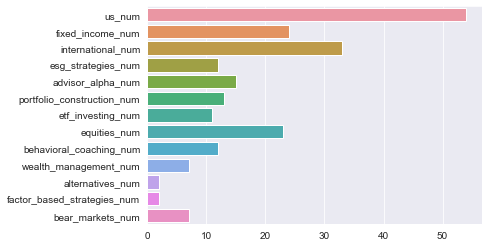

In [66]:
sns.set_style('darkgrid')
sns.barplot(y=list(d.keys()),x=list(d.values()))
plt.show()

In [13]:
VanguardInsights.save_to_json('vanguard_insight.json', vanguard_insight_list)

In [28]:
driver = webdriver.Chrome()
driver.get('https://www.allianzgi.com/en/insights/outlook-and-commentary')
sleep(10)
# tag_list = [i for i in driver.find_elements(By.CSS_SELECTOR, '#insights-archive-section .tags')]

In [26]:
tag_listd

['Fixed IncomeU.S.Bear Markets',
 'ESG StrategiesEquities',
 "Advisor's Alpha®Behavioral CoachingPortfolio Construction",
 'Fixed Income',
 '',
 'Portfolio Construction',
 'Fixed IncomePortfolio Construction',
 'Fixed Income']